In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

valid_target_properties = []

In [16]:
# target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']
# target_property_list = ['voltage', 'energy', 'conductivity', 'capacity', 'columbic_efficiency']
target_property_list = ['voltage']

In [17]:
# gnn_data = pd.read_csv(f'GNN_embedding/data0.csv')

In [18]:
text_data=pd.read_csv(f'text_embedding/embeddings_matbert-base-cased_robo_75966.csv')
text_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

## Train Models

In [7]:
# ## Evaluate with a set aside test set 

# # Main loop
# for target_property in target_property_list:
#     try:
#         df1 = pd.read_excel(f'data/{target_property}.xlsx')
#     except Exception as e:
#         print(f"Failed to load data for {target_property}: {e}")
#         continue

#     avg_df = df1.groupby('jid')['Value'].mean().reset_index()
#     avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

#     merged_df = pd.merge(avg_df, text_data, left_on='jid', right_on='id')
#     merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

#     # Ensure enough data
#     if merged_df.shape[0] < 10:
#         print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
#         continue

#     # Extract features and target
#     X = merged_df.drop(columns=['Value', 'id', 'jid'])
#     X = X.select_dtypes(include=[np.number])  # only numeric features
#     y = merged_df['Value'].values

#     if X.shape[0] != len(y):
#         print(f"Skipping {target_property} due to X/y shape mismatch.")
#         continue

#     # Normalize features for MLP/KNN
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     # Split data
#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

#     # Store valid target property for plotting
#     valid_target_properties.append(target_property)

#     # Train and evaluate models
#     models = {
#         "Linear Regression": LinearRegression(),
#         "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
#         "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
#         "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
#         "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
#     }

#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         r2 = r2_score(y_test, y_pred)
#         r2_scores[name].append(r2)

#         mae = mean_absolute_error(y_test, y_pred)
#         mae_scores[name].append(mae)

#         print(f"{name} R² for {target_property}: {r2:.4f}")


In [8]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

for target_property in target_property_list:
    print(f"STARTING PROPERTY {target_property.upper()}")
    try:
        df1 = pd.read_excel(f'data/{target_property}_2022.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, text_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        print(f"Starting model {name}")
        fold_r2_accuracies = [] 
        fold_mae_accuracies = [] 

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies.append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies.append(mae)

            # print(f"Completed fold {fold} with MAE {mae}")

        mae_scores[name].append(np.average(fold_mae_accuracies))
        r2_scores[name].append(np.average(fold_r2_accuracies))

        print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")

        # print(f"{name} R² for {target_property}: {r2:.4f}")

STARTING PROPERTY VOLTAGE
Starting model Linear Regression
Finished property Linear Regression with average MAE 1.2941273573343266
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 0.699704837259095
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 0.6239643414787336
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 0.6660701176560511
Starting model Decision Tree Regressor
Finished property Decision Tree Regressor with average MAE 0.8521798329468415


In [9]:
mae_scores

{'Linear Regression': [1.2941273573343266],
 'MLP Regressor': [0.699704837259095],
 'Random Forest Regressor': [0.6239643414787336],
 'KNN Regressor': [0.6660701176560511],
 'Decision Tree Regressor': [0.8521798329468415]}

## Plot Final Scores

Use mae_scores or r2_scores to pick a metric

In [10]:
# plt.rcParams.update({'font.size': 10})
# x = np.arange(len(valid_target_properties))
# width = 0.15
# fig, ax = plt.subplots(figsize=(10, 5))

# def split_scores(scores):
#     """Return (valid_scores, invalid_flags)"""
#     visible = [v if v >= 0 else 0 for v in scores]
#     invalid_flags = [v < 0 for v in scores]
#     return visible, invalid_flags

# def plot_model(ax, offset, scores, label, color):
#     visible, is_invalid = split_scores(scores)
#     rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

#     # Draw hatched rectangles for invalid scores at fixed height
#     hatch_height = 0.05  # fixed height for placeholder
#     for i, invalid in enumerate(is_invalid):
#         if invalid:
#             ax.bar(x[i] + offset, hatch_height, width,
#                    fill=False, hatch='//', edgecolor=color, linewidth=1)

#     return rects_visible

# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"], 'Linear Regression', colors[0])
# rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"], 'MLP Regressor', colors[1])
# rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
# rects4 = plot_model(ax, width, mae_scores["KNN Regressor"], 'KNN Regressor', colors[3])
# rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# # Format axes
# ax.set_xlabel('Target Property')
# ax.set_ylabel('Test MAE Score')
# ax.set_title('Test MAE Scores by Model and Target Property (10-fold cross validation)')
# ax.set_xticks(x)
# ax.set_xticklabels([prop.title() for prop in target_property_list], rotation=0, ha='center')
# ax.legend()
# # ax.set_ylim(0, 0.8)  # Set max height to 0.8

# # Annotate only positive R² values
# def add_annotations(rects):
#     for rect in rects:
#         height = rect.get_height()
#         if height >= 0.01:
#             ax.annotate(f'{height:.2f}',
#                         xy=(rect.get_x() + rect.get_width() / 2, height),
#                         xytext=(0, 3),
#                         textcoords="offset points",
#                         ha='center', va='bottom')

# for rect_set in [rects1, rects2, rects3, rects4, rects5]:
#     add_annotations(rect_set)

# fig.tight_layout()
# plt.show()


[0] -0.3 [1.2941273573343266] 0.15 Linear Regression tab:blue
<BarContainer object of 1 artists>
[0] -0.15 [0.699704837259095] 0.15 MLP Regressor tab:orange
<BarContainer object of 1 artists>
[0] 0 [0.6239643414787336] 0.15 Random Forest Regressor tab:green
<BarContainer object of 1 artists>
[0] 0.15 [0.6660701176560511] 0.15 KNN Regressor tab:red
<BarContainer object of 1 artists>
[0] 0.3 [0.8521798329468415] 0.15 Decision Tree Regressor tab:purple
<BarContainer object of 1 artists>


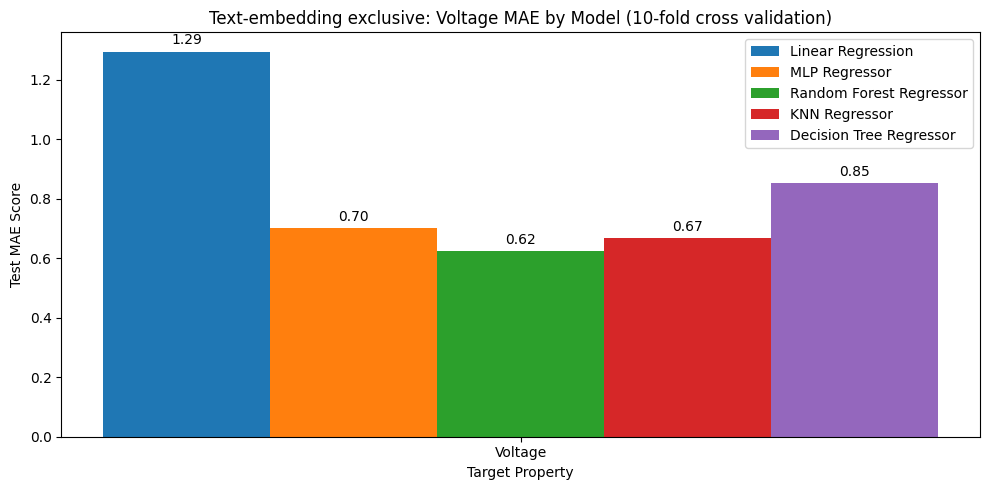

In [11]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores([scores[0]])
    rects_visible = ax.bar(x[0] + offset, visible, width, label=label, color=color)
    print(x, offset, visible, width, label, color)
    print(rects_visible)

    # Draw hatched rectangles for invalid scores at fixed height
    # hatch_height = 0.05  # fixed height for placeholder
    # for i, invalid in enumerate(is_invalid):
    #     if invalid:
    #         ax.bar(x[i] + offset, hatch_height, width,
    #                fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Text-embedding exclusive: Voltage MAE by Model (10-fold cross validation)')
ax.set_xticks([0])

ax.set_xticklabels(['Voltage'], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()


## Hyperparameter search

In [12]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

target_property = "voltage"
df1 = pd.read_excel(f'data/{target_property}_2022.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, text_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values

# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
}


In [14]:
## running the hyperparameter search 
## took 62:32 minutes for graph embeddings 

from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
param_list = list(ParameterSampler(param_dist, n_iter=50, random_state=42))
results = []

for params in tqdm(param_list):
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1, criterion='absolute_error')
    scores = []
    for train_idx, val_idx in kf.split(X):  # manually perform CV
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        mse = mean_absolute_error(y[val_idx], y_pred)
        scores.append(mse)
    results.append((params, np.mean(scores)))

 96%|█████████▌| 48/50 [18:51:32<47:08, 1414.42s/it]  


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results, columns=['params', 'mean_score'])

params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

In [ ]:
results_df.to_csv("random_forest_results.csv", index=False)

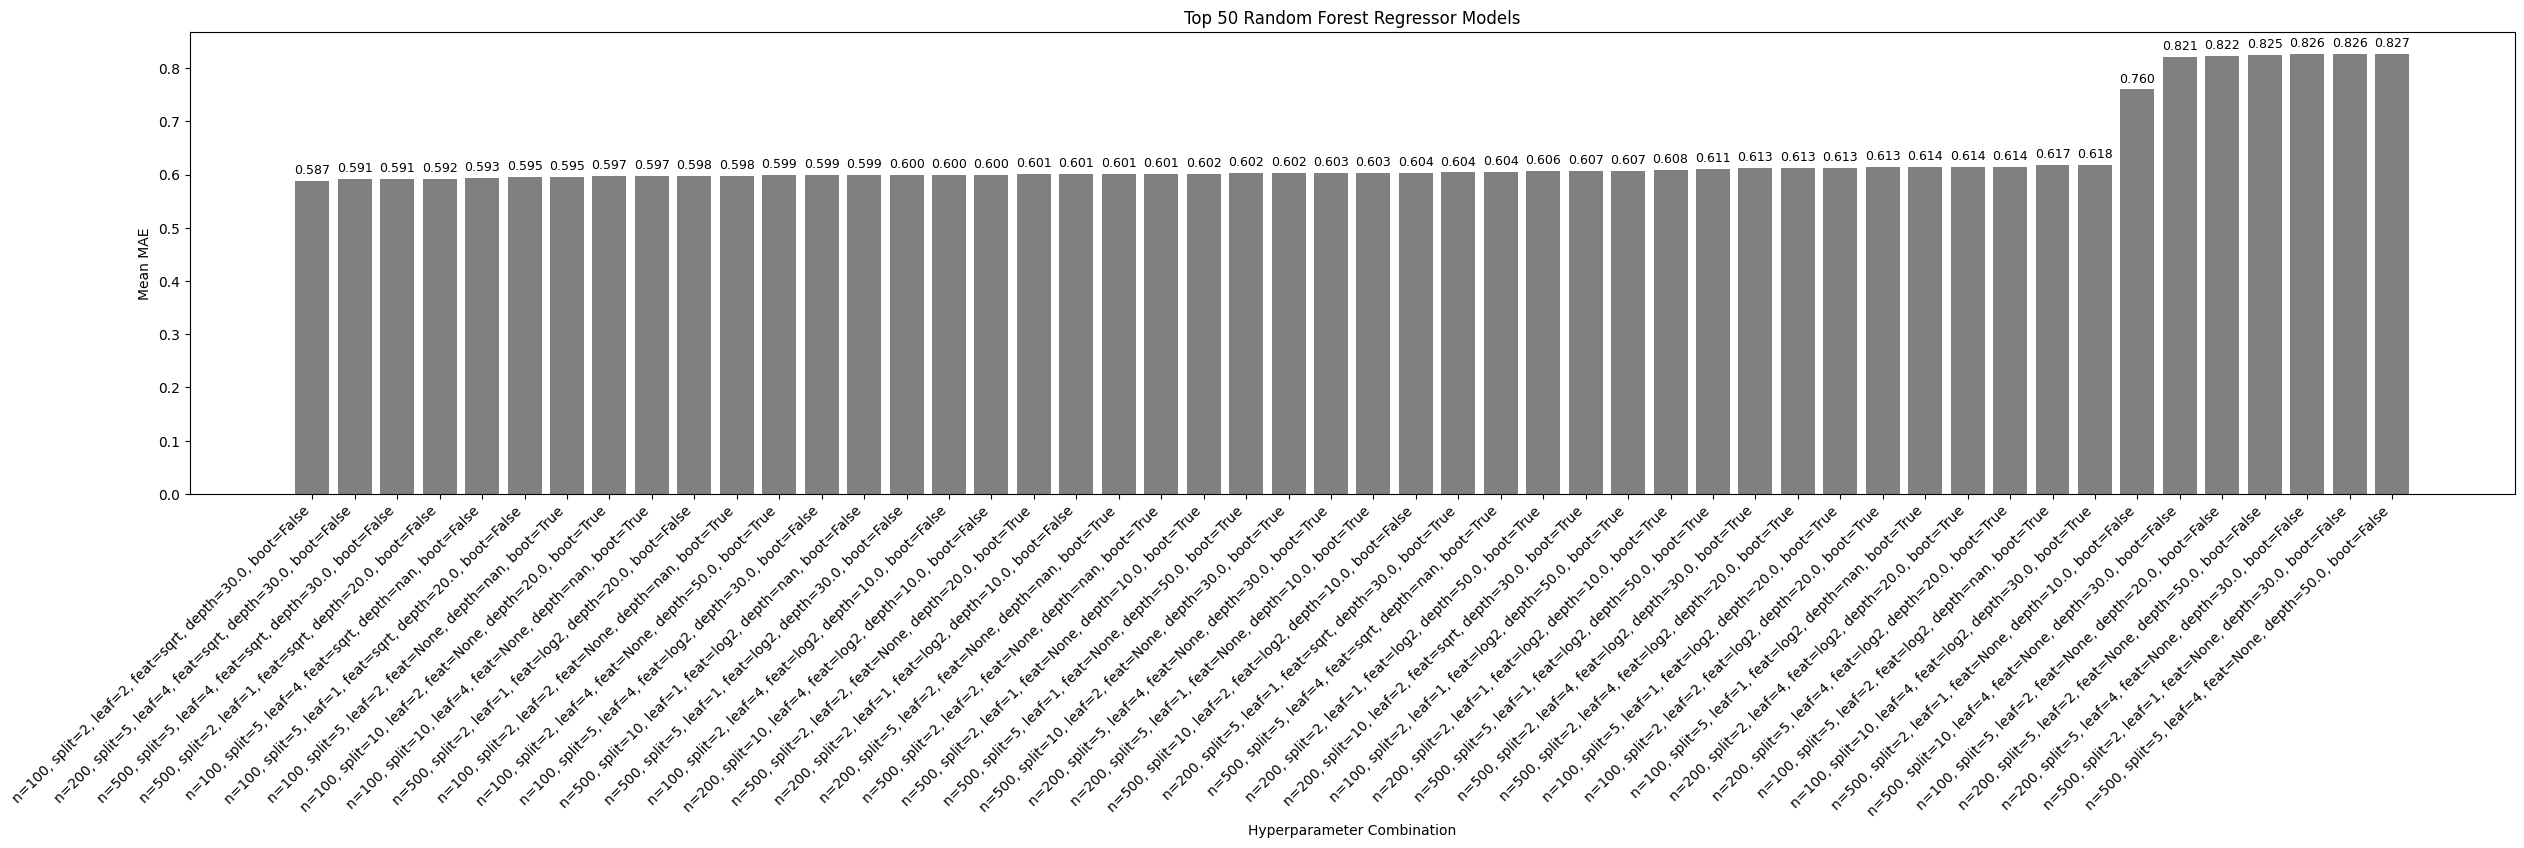

In [ ]:
import matplotlib.pyplot as plt



# Sort and select top N models
top_n = 50
plot_df = results_df.sort_values("mean_score").head(top_n).copy()

# Create readable labels
plot_df["params_str"] = plot_df.apply(
    lambda row: f"n={row.n_estimators}, split={row.min_samples_split}, leaf={row.min_samples_leaf}, feat={row.max_features}, depth={row.max_depth}, boot={row.bootstrap}",
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(30, 6))
bars = ax.bar(plot_df["params_str"], plot_df["mean_score"], color="gray")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(plot_df["mean_score"]),
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Labels and layout
ax.set_ylabel("Mean MAE")
ax.set_xlabel("Hyperparameter Combination")
ax.set_title(f"Top {top_n} Random Forest Regressor Models")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()


In [ ]:
results_df

,mean_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
30,0.587316,100,2,2,sqrt,30.0,False
1,0.591118,200,5,4,sqrt,30.0,False
32,0.591330,500,5,4,sqrt,30.0,False
9,0.592173,500,2,1,sqrt,20.0,False
15,0.592812,100,5,4,sqrt,NaN,False
49,0.594847,100,5,1,sqrt,20.0,False
10,0.595456,100,5,2,None,NaN,True
11,0.597442,100,10,2,None,20.0,True
29,0.597498,100,10,4,None,NaN,True
7,0.597511,500,2,1,log2,20.0,False


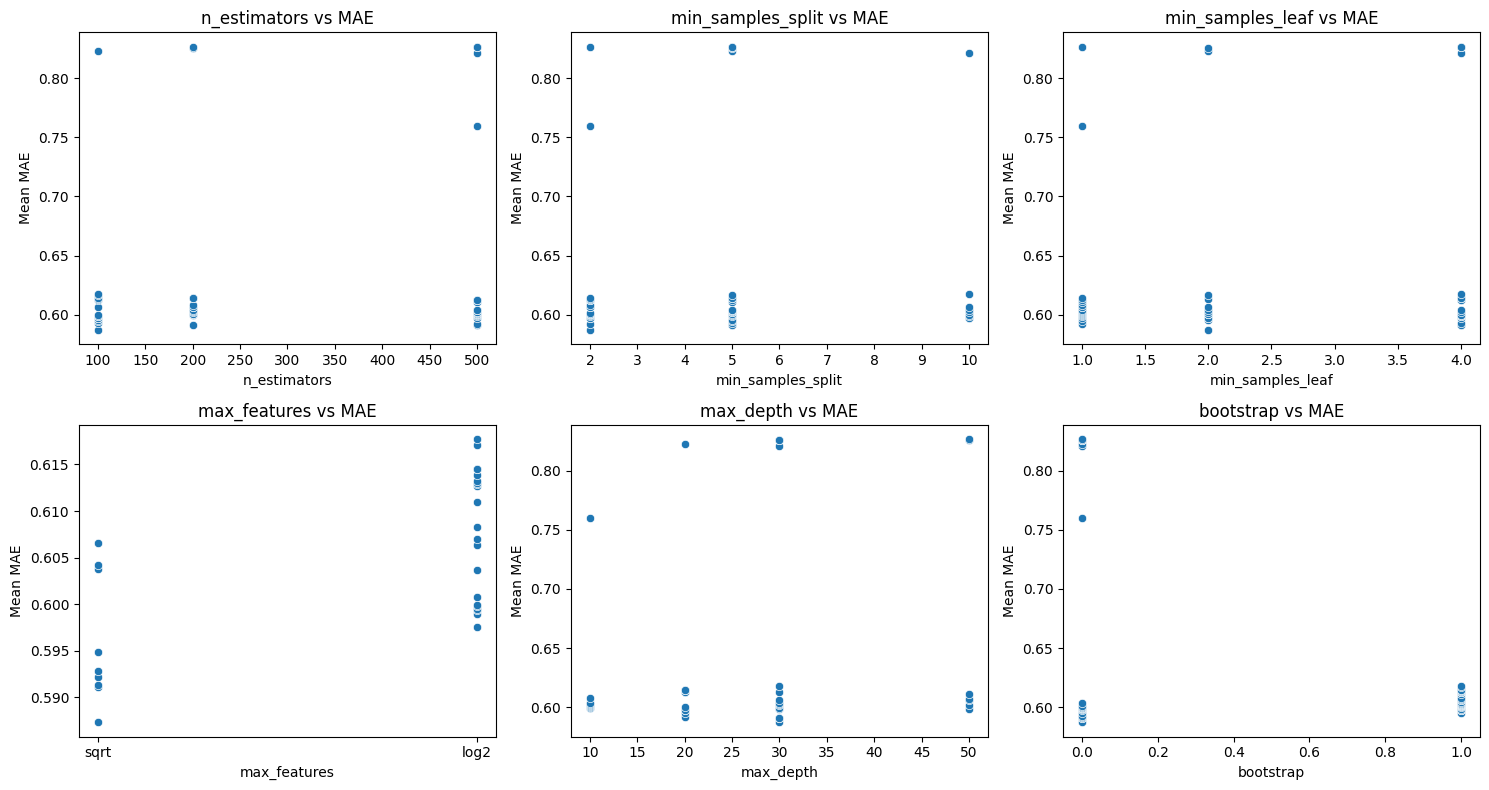

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Drop columns we don't want to plot (like strings or duplicate metrics)
# param_columns = [col for col in results_df.columns if col != "mean_score"]

# # Set up a subplot grid
# n_cols = 3  # Number of columns in the grid
# n_rows = (len(param_columns) + n_cols - 1) // n_cols

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
# axes = axes.flatten()

# # Create one scatterplot per hyperparameter
# for i, param in enumerate(param_columns):
#     sns.scatterplot(data=results_df, x=param, y='mean_score', ax=axes[i])
#     axes[i].set_title(f"{param} vs MAE")
#     axes[i].set_xlabel(param)
#     axes[i].set_ylabel("Mean MAE")

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

In [ ]:
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

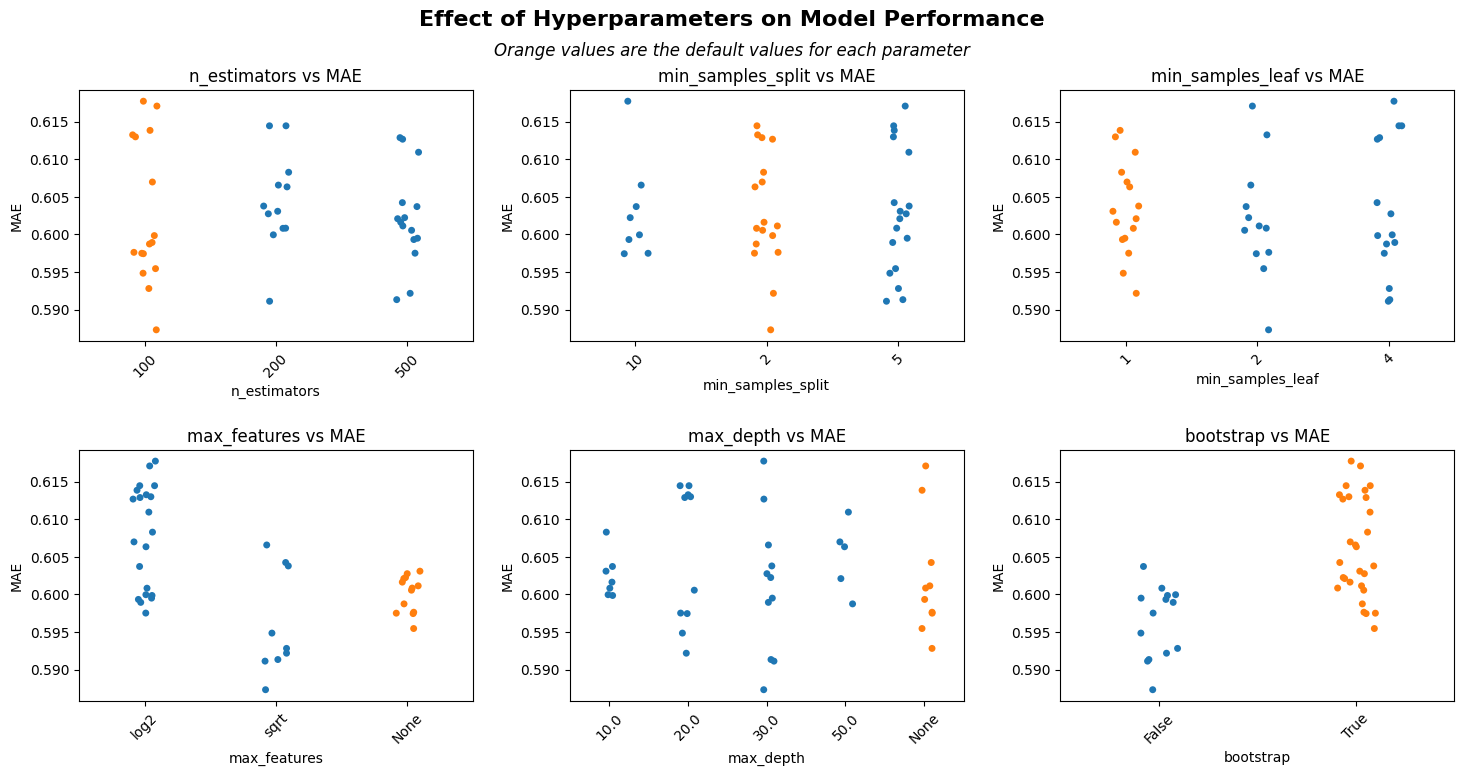

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the default features
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

# Filter out outliers with high MAEs for clear visualization
filtered_df = results_df[results_df["mean_score"] <= 0.75].copy()

# Drop only the score column; include all params
param_columns = [col for col in results_df.columns if col != "mean_score"]

# Convert all param columns to string for consistent plotting
plot_df = filtered_df.copy()
for col in param_columns:
    plot_df[col] = plot_df[col].astype(str).replace("nan", "None")

# Set up subplot grid
n_cols = 3
n_rows = (len(param_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each parameter vs. mean_score
for i, param in enumerate(param_columns):

    default_value = str(defaults[param])
    plot_df['is_default'] = plot_df[param] == default_value

    ordering = sorted(plot_df[param].unique(), key=lambda x: (x == "nan" or x == "None", x)) # put the nan values at the end 
    sns.stripplot(data=plot_df, x=param, y='mean_score', ax=axes[i], order=ordering, jitter=True, hue='is_default', legend=False)
    axes[i].set_title(f"{param} vs MAE")
    # axes[i].set_xlabel(param)
    axes[i].set_ylabel("MAE")
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle("Effect of Hyperparameters on Model Performance", fontsize=16, fontweight='bold')
fig.text(0.5, 0.94, "Orange values are the default values for each parameter", ha='center', va='top', fontsize=12, style='italic')

plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# # Train and evaluate models

# param_dist = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy', 'log_loss']
# }


# models = {
#     "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
# }

# for name, model in models.items():
#     print(f"Starting model {name}")
#     fold_r2_accuracies = [] 
#     fold_mae_accuracies = [] 

#     for fold, (train_index, test_index) in enumerate(kf.split(X)):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
    

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         r2 = r2_score(y_test, y_pred)
#         fold_r2_accuracies.append(r2)

#         mae = mean_absolute_error(y_test, y_pred)
#         fold_mae_accuracies.append(mae)

#         # print(f"Completed fold {fold} with MAE {mae}")

#     mae_scores[name].append(np.average(fold_mae_accuracies))
#     r2_scores[name].append(np.average(fold_r2_accuracies))

#     print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")

#     # print(f"{name} R² for {target_property}: {r2:.4f}")

## Final Evaluation 

In [20]:
best_hyperparameters = {
    "n_estimators": 200,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "max_features": 'log2',
    'max_depth': 10, 
    "criterion": 'absolute_error',
    'bootstrap': False
}

Completed fold 0 with MAE 0.45086168929105436 and R^2 0.1943630176077783
Completed fold 1 with MAE 0.5906437054391802 and R^2 0.08671574740304666
Completed fold 2 with MAE 0.5579812475554421 and R^2 -0.038010103607277745
Completed fold 3 with MAE 0.6314245760125713 and R^2 0.10988085494059097
Completed fold 4 with MAE 0.7533797831796258 and R^2 0.08999697871381007
Completed fold 5 with MAE 0.7056487290735083 and R^2 -0.05415027534643202
Completed fold 6 with MAE 0.6580791750632882 and R^2 0.0886304965610345
Completed fold 7 with MAE 0.5372012142261023 and R^2 0.11109827177622633
Completed fold 8 with MAE 0.6896251409493476 and R^2 0.038163055544206737
Completed fold 9 with MAE 0.5457051759203556 and R^2 0.05794695543638084


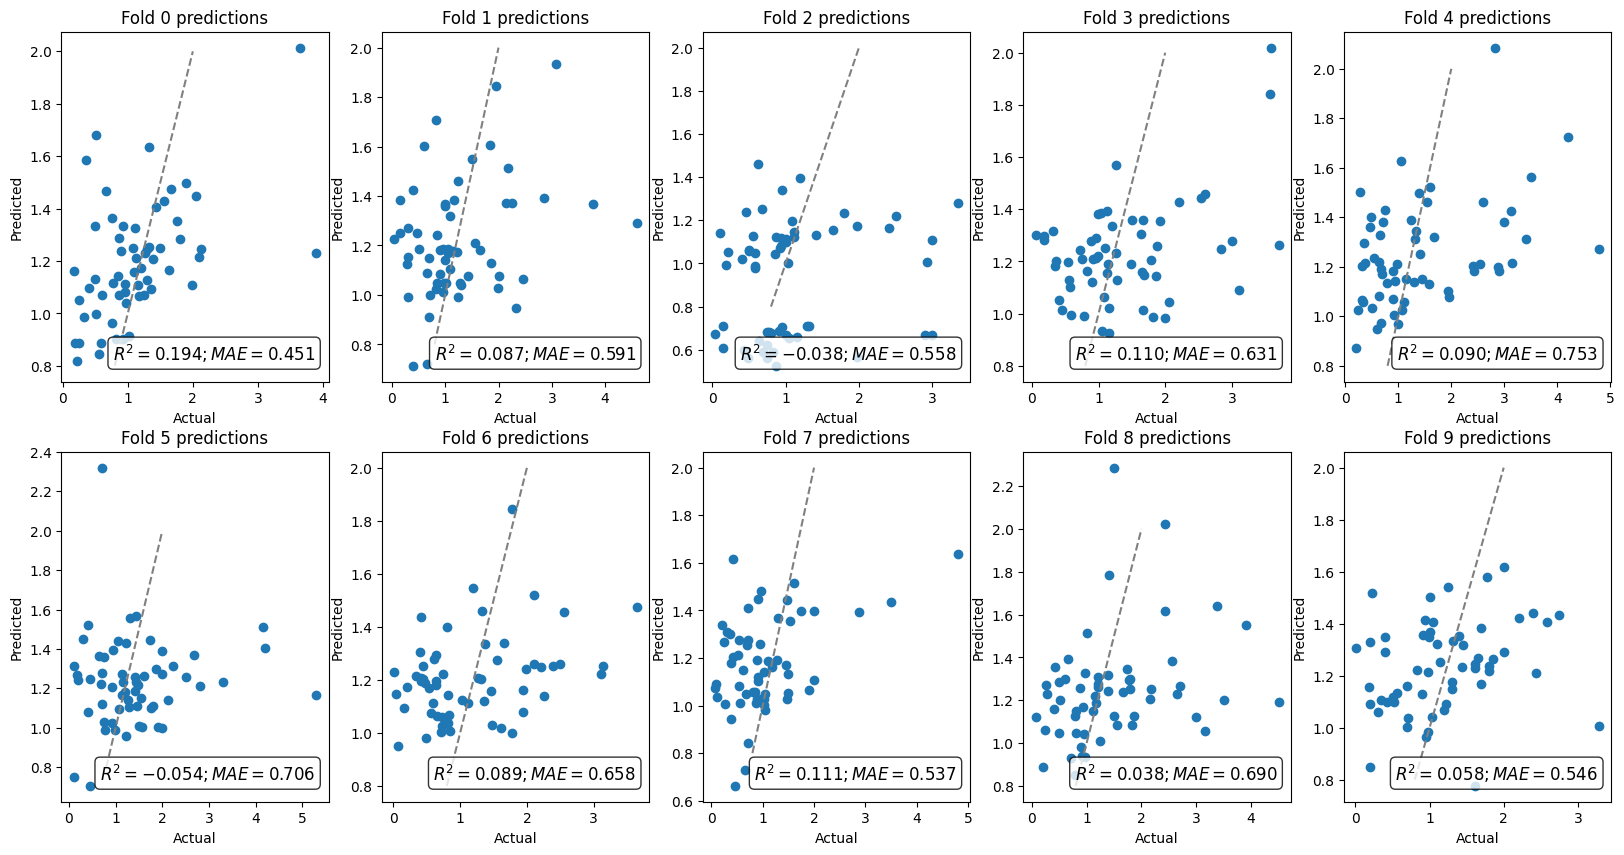

In [47]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

df1 = pd.read_excel(f'data/voltage_2022.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, text_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values


# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train and evaluate models
model = RandomForestRegressor(**best_hyperparameters, random_state=42)

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
plt.title("Text-only Optimized Model Prediction Performance")

fold_r2_accuracies = [] 
fold_mae_accuracies = [] 

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    fold_r2_accuracies.append(r2)

    mae = mean_absolute_error(y_test, y_pred)
    fold_mae_accuracies.append(mae)

    current_ax = axes[int(fold >= 5)][fold % 5]

    current_ax.scatter(y_test, y_pred)
    current_ax.set_xlabel("Actual")
    current_ax.set_ylabel("Predicted")
    current_ax.set_title(f"Fold {fold} predictions")
    current_ax.plot([0.8, 2], [0.8, 2], linestyle='--', color='gray', label='Ideal')

    current_ax.text(0.95, 0.05, f"$R^2 = {r2:.3f}; MAE = {mae:.3f}$",
                transform=current_ax.transAxes,
                fontsize=12,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


    print(f"Completed fold {fold} with MAE {mae} and R^2 {r2}")
plt.show()


In [40]:
axes[int(fold >= 5)][fold % 5]

<Axes: >

In [25]:
print("Target mean:", np.mean(y))
print("Target std:", np.std(y))
print("Range of y:", np.min(y), "-", np.max(y))

Target mean: 1.2546002699476035
Target std: 0.884357594569069
Range of y: 0.011499999999999967 - 5.300000000000001
